In [1]:
import os
import time
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_image

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.regularizers import l1

from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.utils import image_dataset_from_directory

2024-06-17 18:09:26.039993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 18:09:26.040041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 18:09:26.041510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.__version__)

2.15.0


Found 4203 files belonging to 20 classes.
Using 3363 files for training.
Found 4203 files belonging to 20 classes.
Using 840 files for validation.


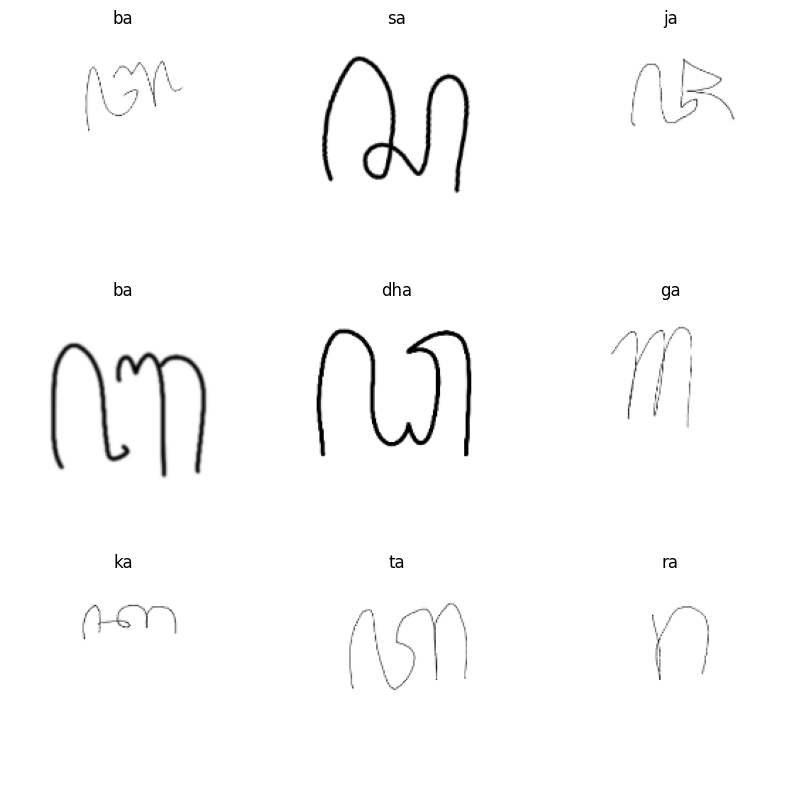

In [3]:
IMG_SIZE = 160
img_width, img_height = 160, 160
batch_size = 50

# Membuat dataset pelatihan dan validasi
train_dataset = image_dataset_from_directory(
    '/kaggle/input/aksara-jawa-dataset/data',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    '/kaggle/input/aksara-jawa-dataset/data',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width,img_height),
    batch_size=batch_size,
    shuffle=True
)

# Mendapatkan nama kelas dari direktori
class_names = train_dataset.class_names

# Plot beberapa gambar dari dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [4]:
model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(160, 160, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Conv2D(512, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(20, activation='softmax')
])

# Print the model summary
model.summary()

# Set the training parameters
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 158, 158, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 79, 79, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 77, 77, 64)        2

In [5]:
from tensorflow.keras.utils import image_dataset_from_directory
epochs = 500

# Callback untuk early stopping, reduce learning rate, dan model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Custom callback to print a message when training stops
class CustomCallback(Callback):
    def on_train_end(self, logs=None):
        print("Stop Training")
custom_callback = CustomCallback()

# Evaluate the model before training
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

# Training model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, custom_callback]
)


# Evaluasi model
# Evaluate the model after training
loss, accuracy = model.evaluate(validation_dataset)
print("final loss: {:.2f}".format(loss))
print("final accuracy: {:.2f}".format(accuracy))

17/17 [==============================] - 2s 50ms/step - loss: 70.7198 - accuracy: 0.0488
initial loss: 70.72
initial accuracy: 0.05
Epoch 1/500


2024-06-17 18:10:53.876890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718647855.857642    3324 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 [==============================] - 12s 73ms/step - loss: 4.2704 - accuracy: 0.2010 - val_loss: 8.4392 - val_accuracy: 0.2071 - lr: 0.0010
Epoch 2/500


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 5s 65ms/step - loss: 3.1968 - accuracy: 0.4178 - val_loss: 3.1486 - val_accuracy: 0.4964 - lr: 0.0010
Epoch 3/500
68/68 [==============================] - 4s 61ms/step - loss: 2.7392 - accuracy: 0.5225 - val_loss: 9.4808 - val_accuracy: 0.1690 - lr: 0.0010
Epoch 4/500
68/68 [==============================] - 4s 62ms/step - loss: 2.4204 - accuracy: 0.5873 - val_loss: 6.1297 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 5/500
68/68 [==============================] - 4s 62ms/step - loss: 2.1943 - accuracy: 0.6500 - val_loss: 14.7825 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/500
68/68 [==============================] - 4s 61ms/step - loss: 2.0417 - accuracy: 0.6910 - val_loss: 5.9815 - val_accuracy: 0.1798 - lr: 0.0010
Epoch 7/500
68/68 [==============================] - 5s 64ms/step - loss: 1.8512 - accuracy: 0.7416 - val_loss: 2.4485 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 8/500
68/68 [==============================] - 4s 61ms/step - loss: 1.7948 

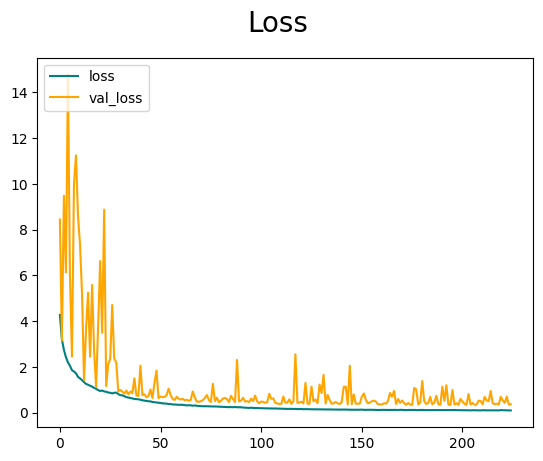

In [11]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

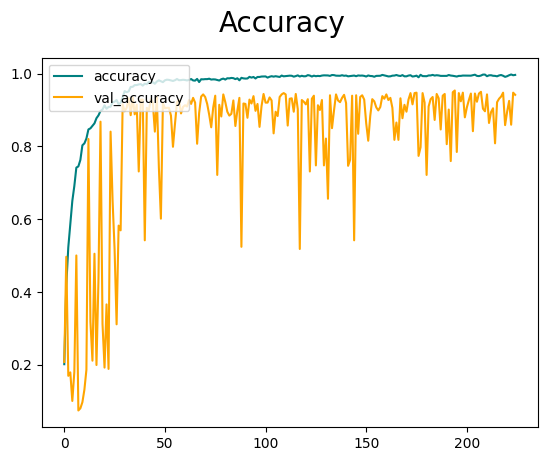

In [12]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Fungsi untuk memuat dan mempersiapkan gambar
def load_and_prepare_image(file_path, img_width, img_height):
    img = image.load_img(file_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Membuat batch yang terdiri dari satu gambar
    return img_array

# Memprediksi gambar baru
file_path = '/kaggle/input/aksara-jawa-dataset/data-test/nya.png'  # Ganti dengan path ke gambar yang ingin diprediksi
img_width, img_height = 160, 160  # Ganti dengan dimensi yang sesuai dengan model
img_array = load_and_prepare_image(file_path, img_width, img_height)

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)

# Mendapatkan nama kelas dari class _names
predicted_class_name = train_dataset.class_names[predicted_class_index[0]]

print(f"Prediksi huruf aksara: {predicted_class_name}")


1/1 [==============================] - 0s 388ms/step
Prediksi huruf aksara: nya


# Simpan Model

In [6]:
# Mengonversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TensorFlow Lite ke file
with open('aksara_jawa_model.tflite', 'wb') as f:
    f.write(tflite_model)

Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 25, Total Ops 52, % non-converted = 48.08 %
 * 25 ARITH ops

- arith.constant:   25 occurrences  (f32: 24, i32: 1)



  (f32: 5)
  (f32: 5)
  (f32: 2)
  (f32: 5)
  (f32: 5)
  (f32: 1)
  (f32: 1)


In [7]:
!pip install tensorflowjs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [9]:
# Convert Model
# To JSON
!tensorflowjs_converter --input_format=keras /kaggle/working/best_model.h5 /tfjs_model

2024-06-17 18:31:50.851885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 18:31:50.851937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 18:31:50.853265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
